# Assignment 5

*ZM MW*

Nagel-Schreckenberg model

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import imageio
import os
import shutil
import random

In [18]:
class NagelSchreckenberg:
    
    def __init__(self, road_length = 100, time = 100, rho = 0.1, p = 0.2, v_max = 5):
        self.road_length = road_length
        self.time = time
        self.rho = rho        # density of cars
        self.p = p            # probability of accident = slowing down
        self.v_max = v_max    # speed limit
        self.initial_positions = random.sample(list(range(self.road_length)), round(self.rho * self.road_length))
        self.grid = np.reshape([None] * self.road_length * self.time, (self.time, self.road_length))
        self.grid[0,self.initial_positions] = 0
        self.avg_velocities = []
        self.avg_velo_grid = []
        
    def run(self): 
        for i in range(1,self.time):
            self.cars_positions = np.where(self.grid[i-1,:] != None)[0].tolist()   
            self.velocities = self.grid[i-1,self.cars_positions]
            self.velocities = [velo + 1 if velo < self.v_max else velo for velo in self.velocities]  # 1. acceleration

            # periodic boundary:
            self.extended_cars_positions = self.cars_positions + (np.array(self.cars_positions)+self.road_length).tolist()
            self.extended_velocities = self.velocities + self.velocities
            
            self.new_cars_positions = []
            self.new_velocities = []
            for car in range(len(self.cars_positions)):
                if self.cars_positions[car] + self.velocities[car] < self.extended_cars_positions[car+1]:
                    self.new_cars_positions.append(self.cars_positions[car] + self.velocities[car])
                    self.new_velocities.append(self.velocities[car])
                else:
                    self.new_cars_positions.append(self.extended_cars_positions[car+1] - 1)  # 2. slowing down if crash possible
                    self.new_velocities.append(self.new_cars_positions[car] - self.cars_positions[car])
                    
                if (random.random() < self.p) & (self.new_velocities[car] > 0):   # 3. randomization
                    self.new_cars_positions[car] = self.new_cars_positions[car] - 1
                    self.new_velocities[car] = self.new_velocities[car] - 1                
            
            self.new_cars_positions = [pos - self.road_length if pos >= self.road_length else pos for pos in self.new_cars_positions]
            self.grid[i,self.new_cars_positions] = self.new_velocities   # 4. motion
            self.avg_velocities.append(np.mean(self.new_velocities))
        self.avg_velo_grid = np.mean(self.avg_velocities)
                        

In [19]:
x = NagelSchreckenberg(road_length=10, time=7, rho=0.3)

In [20]:
x.run()
x.grid
x.avg_velocities
x.avg_velo_grid

1.1666666666666667

#### Functions to ilustrate and animate the model.

In [21]:
# returns the matrix of only cars placement

def where_are_the_cars(road_length = 100, time = 100, rho = 0.1, p = 0.2, v_max = 5):
    experiment = NagelSchreckenberg(road_length, time, rho, p, v_max)
    experiment.run()
    cars = experiment.grid.copy()
    cars[np.where(cars != None)] = 1   # cars are ones
    cars[np.where(cars == None)] = 0   # empty spaces are zeros
    cars = cars.astype('float64') 
    return cars

In [22]:
def picture(road_length = 100, time = 100, rho = 0.1, p = 0.2, v_max = 5):
    picture_path = "length={N}_rho={rho}_p={p}_vmax={v_max}_simulation.jpg".format(N = road_length, rho=rho, p=p, v_max=v_max)

    cmap = colors.ListedColormap(['whitesmoke', 'hotpink'])
    
    cars = where_are_the_cars(road_length, time, rho, p, v_max)

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.grid()
    ax.set_title('Nagel-Schreckenberg model on road of length={N}, rho={rho}, p={p}, vmax={v_max}'.format(N = road_length, rho=rho, p=p, v_max=v_max))

    im = ax.imshow(cars, cmap=cmap)  
    plt.savefig(picture_path)
    plt.show()

In [23]:
def animation(road_length = 100, time = 100, rho = 0.1, p = 0.2, v_max = 5):
    animation_path = "length={N}_rho={rho}_p={p}_vmax={v_max}_simulation.gif".format(N = road_length, rho=rho, p=p, v_max=v_max)

    folder_path = "NagelSchreckenberg_model"

    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)
    os.makedirs(folder_path)

    frames_path = folder_path + "/{i}.jpg"

    cmap = colors.ListedColormap(['whitesmoke', 'hotpink', 'white'])
    
    cars = where_are_the_cars(road_length, time, rho, p, v_max)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111)
    ax.set_axis_off()
    ax.grid()
    ax.set_title('Nagel-Schreckenberg model on road of length={N}, rho={rho}, p={p}, vmax={v_max}'.format(N = road_length, rho=rho, p=p, v_max=v_max))
  
    im = ax.imshow(np.vstack((cars[0], [2]*road_length)).astype('float64'), cmap=cmap) 
    plt.savefig(frames_path.format(i=0))

    for n in range(1,time):          
        im.set_array(np.vstack((cars[n], [2]*road_length)).astype('float64'))  
        plt.savefig(frames_path.format(i=n))

    with imageio.get_writer(animation_path, mode='I') as writer:
        for i in range(n):
            writer.append_data(imageio.imread(frames_path.format(i=i)))


In [16]:
animation(100,100,0.6,0.7)

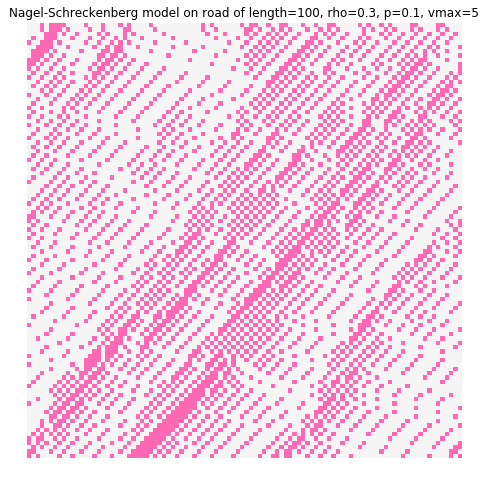

In [20]:
picture(100,100,0.3,0.1)

#### Quick in-code visual comparison for different rho and p.

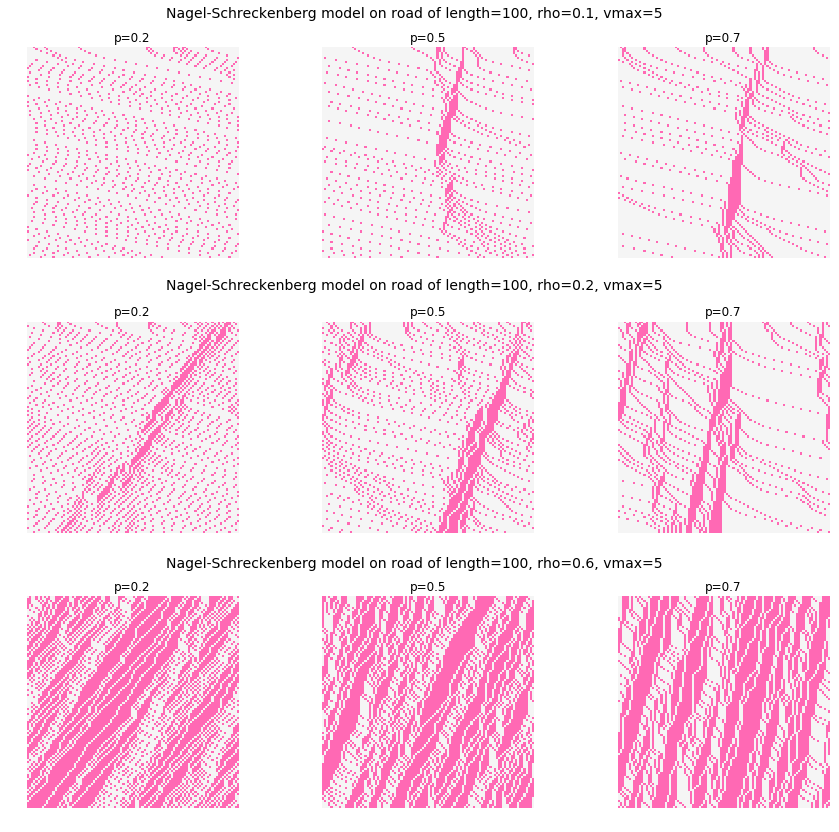

In [27]:
cmap = colors.ListedColormap(['whitesmoke','hotpink'])
fig, axs = plt.subplots(3,3, figsize=(15, 14))

axs = axs.ravel()
i = 0
for rho in [0.1, 0.2, 0.6]:
    for p in [0.2, 0.5, 0.7]:
        axs[i].set_axis_off()
        axs[i].set_title('p={p}'.format(p=p))
        axs[i].imshow(where_are_the_cars(road_length = 100, time = 100, rho = rho, p = p, v_max = 5), cmap=cmap) 
        i += 1 
        
plt.subplots_adjust(hspace = 0.3)
plt.figtext(0.5,0.92, "Nagel-Schreckenberg model on road of length=100, rho=0.1, vmax=5", ha="center", va="top", fontsize=14)
plt.figtext(0.5,0.65, "Nagel-Schreckenberg model on road of length=100, rho=0.2, vmax=5", ha="center", va="top", fontsize=14)
plt.figtext(0.5,0.375, "Nagel-Schreckenberg model on road of length=100, rho=0.6, vmax=5", ha="center", va="top", fontsize=14)
plt.savefig('comparison.jpg')
plt.show()

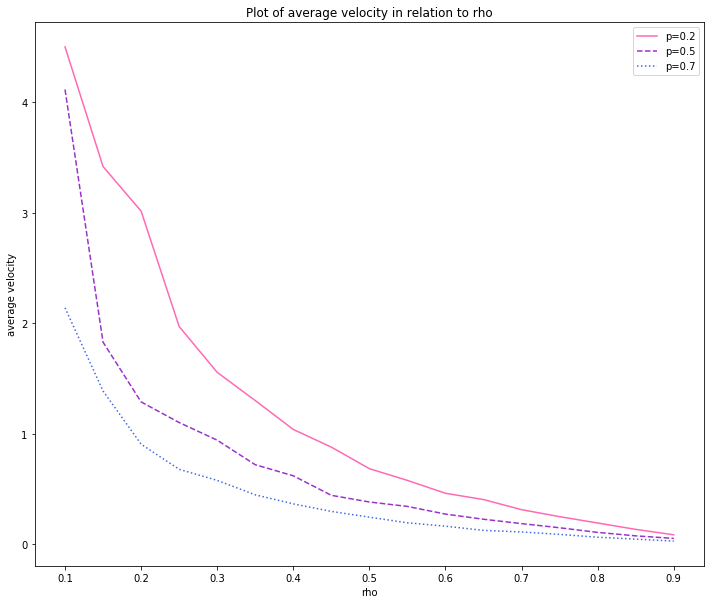

In [28]:
plt.figure(figsize=(12,10))
list_of_rho = np.arange(0.1,0.95,0.05)
p = [0.2,0.5,0.7]
line_style = ['-','--',':']
colors = ['hotpink', 'darkorchid', 'royalblue']
n = 0

for i in p:
    velo_to_plot = []
    for j in range(1,18):
        rho = j*0.05+0.05
        x = NagelSchreckenberg(100,100,rho,i)
        x.run()
        velo_to_plot.append(x.avg_velo_grid)
    plt.plot(list_of_rho,velo_to_plot,line_style[n],color=colors[n])
    n += 1
    
plt.title('Plot of average velocity in relation to rho')
plt.xlabel('rho')
plt.ylabel('average velocity')
plt.legend(['p=0.2', 'p=0.5','p=0.7'], loc=1)
plt.savefig('avg_velocity_rho.jpg')
plt.show()
    